<h1> KNeighborsClassifier <h1>

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import set_config
import seaborn as sns
import warnings

In [23]:
warnings.filterwarnings("ignore", category=FutureWarning)
set_config(display = "diagram")

<h1>Datensatz einlesen<h1>

In [24]:
path = r'./out/df_clean.csv'
df = pd.read_csv(path, sep=';', decimal=',')

In [25]:
df.head()

,DAYS_SINCE_PURCHASE,PURCHASE_VISITS,TOTAL_NET_SALES,CC_CARD,AVE_AMOUNT_SPENT,AMSPEND,PSSPEND,CCSPEND,AXSPEND,TMONSPEND,...,ZIP_CODE_90,ZIP_CODE_91,ZIP_CODE_92,ZIP_CODE_93,ZIP_CODE_94,ZIP_CODE_95,ZIP_CODE_96,ZIP_CODE_97,ZIP_CODE_98,ZIP_CODE_99
0,208,2,368.46,0,184.23,0.0,0.0,368.46,0.0,0.00,...,False,False,False,False,False,False,False,False,False,False
1,6,4,258.00,1,64.50,0.0,0.0,258.00,0.0,138.00,...,False,False,False,False,False,False,False,False,False,False
2,327,2,77.00,0,38.50,0.0,0.0,77.00,0.0,0.00,...,False,False,False,False,False,False,False,False,False,False
3,66,8,846.06,1,105.75,0.0,0.0,846.06,0.0,104.94,...,False,False,False,False,False,False,False,False,False,False
4,49,1,87.44,0,87.44,0.0,0.0,87.44,0.0,87.44,...,False,False,False,False,False,False,False,False,False,False


<h2>Funktionen<h2>

<h3>Funktion für den Train Test Validation Split<h3>

In [26]:
#nimmt Dataframe entgegen und gibt Trainings-, Test- und Validationdataframes im Verhältnins (80%,20%,5%) zurück
def split_train_test(df):
    random_state = 4711
    features = [x for x in df.columns if x!= "RESP"]
    X = df[features]
    y = df["RESP"]
    X_train, X_test_2, y_train, y_test_2 = train_test_split(X, y, test_size = 0.05, random_state=random_state)
    X_train, X_test_1, y_train, y_test_1 = train_test_split(X_train, y_train, test_size = 0.2, random_state=random_state)
    return X_train, X_test_2, y_train, y_test_2, X_test_1, y_test_1

<h3>Funktion für die Errechnung des Gewinns/Verlustes auf Grundlage der Gewinn-/Verlustmatrix<h3>

In [27]:
#nimmt die tatsächlichen und die vorhergesagten Werte als Series entgegen und gibt den auf Grundlage der Aufgabenstellung errechneten Gewinn/Verlust zurück
def get_result_score(y_test, y_predicted):

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    y_true = y_test.to_list()
    y_predicted = y_predicted.tolist()

    for i in range(len(y_predicted)):
        if y_true[i]==y_predicted[i]==1:
            TP += 1
        if y_predicted[i]==1 and y_true[i]!=y_predicted[i]:
            FP += 1
        if y_true[i]==y_predicted[i]==0:
            TN += 1
        if y_predicted[i]==0 and y_true[i]!=y_predicted[i]:
            FN += 1


    return (TP*16+FP*(-2)+TN*(0)+FN*(-16))

In [28]:
# Trainings-,Test- und Vaildationsdaten erstellen
X_train, X_test_2, y_train, y_test_2, X_test_1, y_test_1 = split_train_test(df)

In [29]:
X_test_1.shape

(4131, 172)

<h2>KNearstNeighbor Classifier<h2>

**Betrachtete Hyperparameter KNearst Neighbor**

*  n_neighbors: Anzahl betrachteter Nachbarn
*  weights: Gewichtung der nächsten Nachbarn [uniform, distance]
*  metric: Metrik für die Distanzberechnung [euclidean, minkowski]

<h3>Feature Selection der 10 wichtigsten Features über ANOVA F-Werte<h3>

In [30]:
# Betrachtung der ANOVA F-Werte statt der Chi Quadrat Werte für die Feature Selection, das negative Werte im Datensatz enthalten sind https://stackoverflow.com/questions/25792012/feature-selection-using-scikit-learn"""
skBest_classif = SelectKBest(f_classif, k=10)
std_slc = preprocessing.StandardScaler()
knn = KNeighborsClassifier()

<h3>Erstellen einer Pipeline mit Standardisierung (z-Values), Feature Selection (ANOVA F-Werte) und KNearstNeighbor Modell<h3>

In [31]:
step_order = [("scaler",std_slc),("skBest_classif",skBest_classif),("knn",knn)]
pipe = Pipeline(step_order)
pipe

Pipeline(steps=[('scaler', StandardScaler()), ('skBest_classif', SelectKBest()),
                ('knn', KNeighborsClassifier())])

In [32]:
#zeigt die auf Grundlage des ANOVA F-Werts wichtigsten features
pipe.fit(X_train,y_train)
features = pipe.named_steps['skBest_classif']
X_train.columns[features.get_support()]

Index(['PURCHASE_VISITS', 'TOTAL_NET_SALES', 'SMONSPEND', 'CLASSES', 'COUPONS',
       'STYLES', 'STORES', 'RESPONDED', 'RESPONSERATE', 'LTFREDAY'],
      dtype='object')

In [33]:
# Listen mit 20 Einträgen ertsellen
mean_acc = np.zeros(20)
mean_score = np.zeros(20)
# Schleife mit 20 Iterationen
for i in range(1,21):
    # Je Iteration erstellen und Trainieren eines Knn Modells mit einer Anzahl nächster Nachbarn von 1-20
    pipe.set_params(knn__n_neighbors=i).fit(X_train, y_train)
    # Vorhersage der Klasse auf Grundlage der Test1 Daten
    y_predicted = pipe.predict(X_test_1)
    # Füllen der Listen mit der so erzielten Accuracy und Gewinn/Verlusts
    mean_acc[i-1] = metrics.accuracy_score(y_test_1, y_predicted)
    mean_score[i-1] = get_result_score(y_test_1, y_predicted)

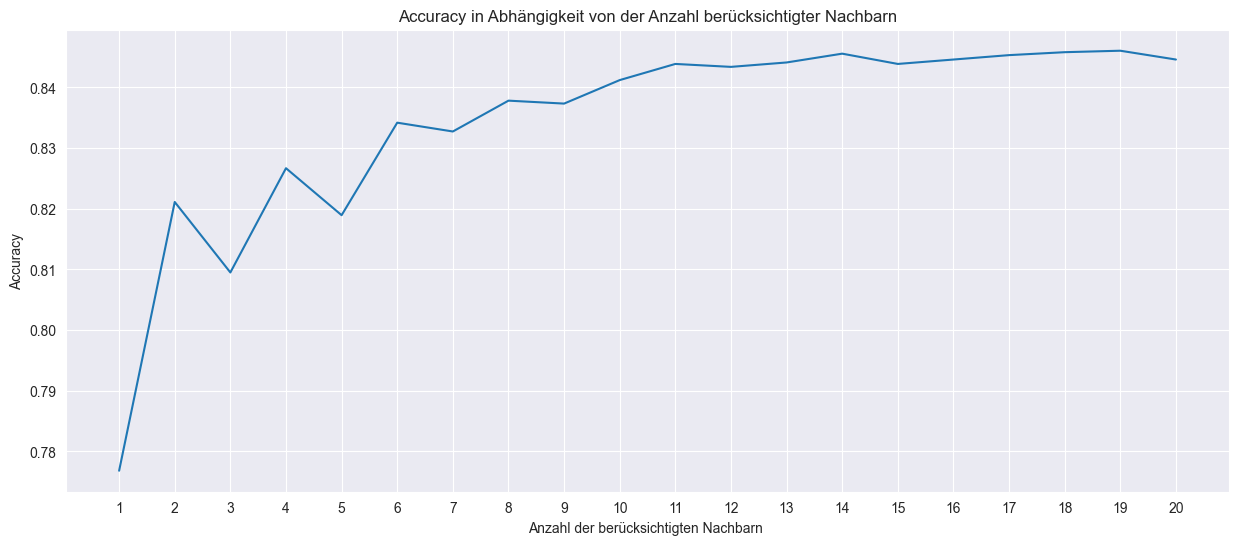

In [34]:
# Darstellung der Accuracy in Abhängigkeit von der Anzahl nächster Nachbarn
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (15, 6))
plt.plot(range(1,21), mean_acc)
plt.xticks(loc)
plt.xlabel('Anzahl der berücksichtigten Nachbarn ')
plt.ylabel('Accuracy')
plt.title("Accuracy in Abhängigkeit von der Anzahl berücksichtigter Nachbarn")
plt.show()

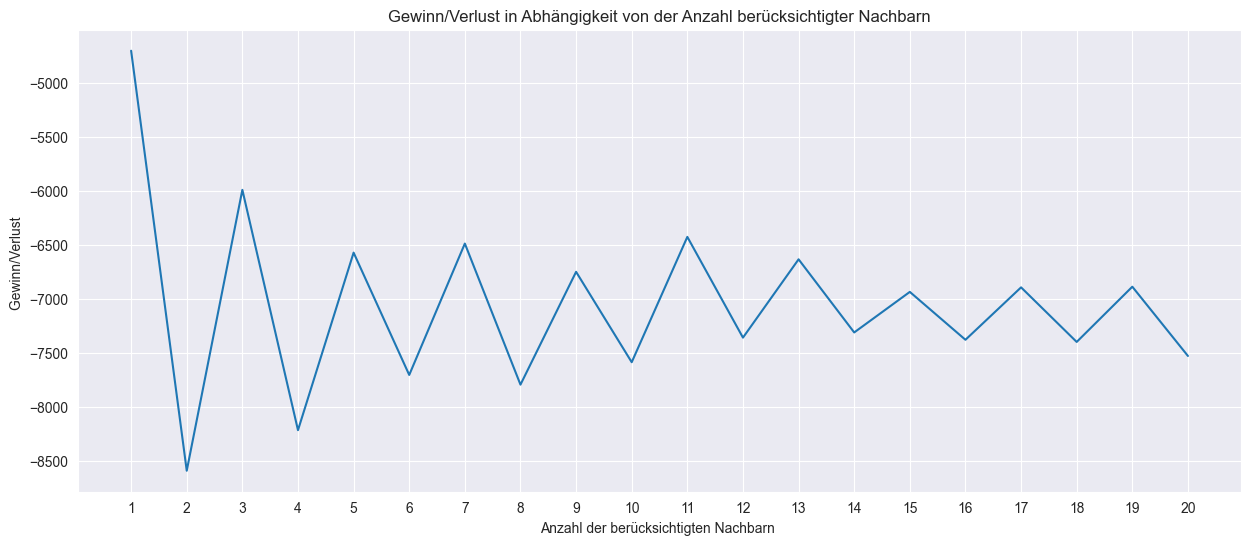

In [35]:
# Darstellung des Gewinns/Verlusts in Abhängigkeit von der Anzahl nächster Nachbarn
loc = np.arange(1, 21, step=1.0)
plt.figure(figsize=(15, 6))
plt.plot(range(1, 21), mean_score)
plt.xticks(loc)
plt.xlabel('Anzahl der berücksichtigten Nachbarn ')
plt.ylabel('Gewinn/Verlust ')
plt.title("Gewinn/Verlust in Abhängigkeit von der Anzahl berücksichtigter Nachbarn")
plt.show()

In [36]:
# Lösungsraum für die Hyperparameteroptimierung festlegen
grid_params = {"knn__n_neighbors" : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
              "knn__weights" : ["uniform","distance"],
              "knn__metric": ["euclidean","manhattan"]
              }

#eigene Funktion als Scorer für die GridSearch
result_scorer = make_scorer(get_result_score)

# GirdSearch mit 3 fold cross validation, Suche über die zuvor definierten Parameter

#Suche nach optimalen Parametern unter Berücksichtigung des Gewinns/Erlöses
knn_random_result_score = GridSearchCV(estimator = pipe, param_grid = grid_params,
                                       cv = 3, n_jobs = -1, scoring = result_scorer, error_score="raise")

#Suche nach optimalen Parametern unter Berücksichtigung der Accuracy
knn_random_result_accuracy = GridSearchCV(estimator=pipe,param_grid = grid_params, cv = 3, n_jobs = -1,error_score="raise")

#Suche nach optimalen Parametern unter Berücksichtigung des Recalls
knn_random_result_recall = GridSearchCV(estimator = pipe, param_grid = grid_params,
                                        cv = 3, n_jobs = -1, scoring = "recall", error_score="raise")

In [37]:
# GridSearch Instanzen mit Trainingsdaten fitten
knn_random_result_score_res = knn_random_result_score.fit(X_train, y_train)
knn_random_result_accuracy_res = knn_random_result_accuracy.fit(X_train, y_train)
knn_random_result_recall_res = knn_random_result_recall.fit(X_train, y_train)

# Ausgabe des jeweils besten Scores und der optimalen dafür genutzten Parameter
print("Bester Score: ",knn_random_result_score_res.best_score_)
print("Mit Parametern: ",knn_random_result_score_res.best_params_)
print("Beste Accuracy: ",knn_random_result_accuracy_res.best_score_)
print("Mit Parametern: ",knn_random_result_accuracy_res.best_params_)
print("Bester Recall: ",knn_random_result_recall_res.best_score_)
print("Mit Parametern: ",knn_random_result_recall_res.best_params_)

Bester Score:  -5820.0
Mit Parametern:  {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Beste Accuracy:  0.8469314290559623
Mit Parametern:  {'knn__metric': 'euclidean', 'knn__n_neighbors': 16, 'knn__weights': 'uniform'}
Bester Recall:  0.33993399339933994
Mit Parametern:  {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}


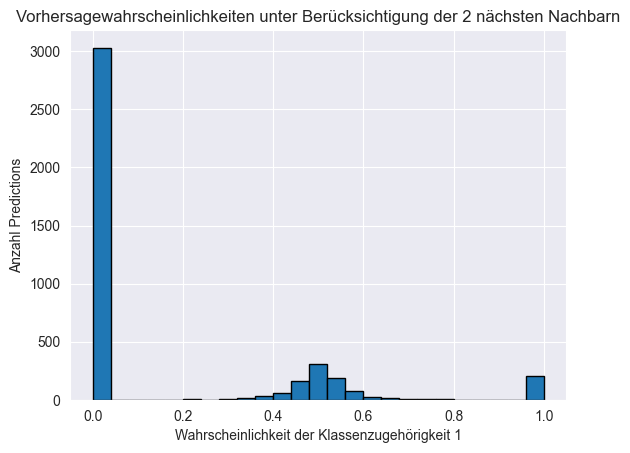

Threshold=  0.0 Score-Wert=  4590 €


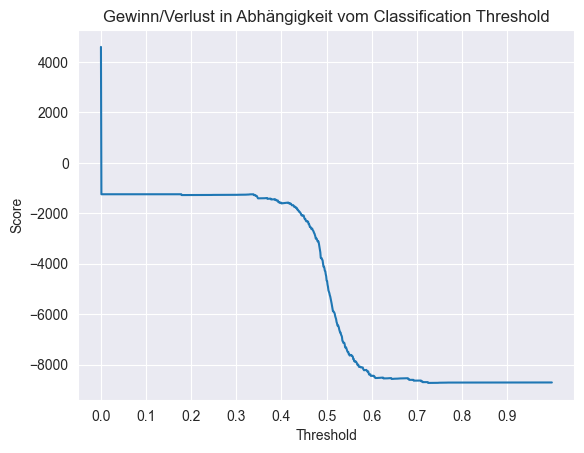

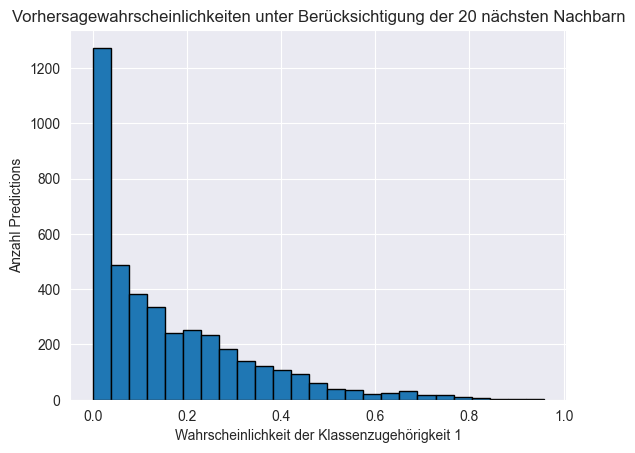

Threshold=  0.038 Score-Wert=  6144 €


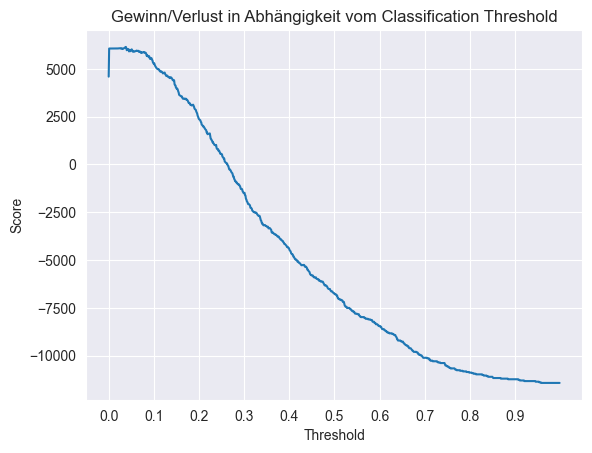

In [38]:
# Funktion die der Threshold Wert und die Wahrscheinlichkeit der Klassenzugehörigkeit 1 entgegennimmt und einen diesen zurückgibt, solange die Wahrscheinlichkeit der Klassenzugehörigkeit über dem Threshold liegt (sonst 0)
def to_labels(probabilities, threshold):
    return(probabilities >= threshold).astype("int")

#Thresholds evaluieren
# Erstellen und Trainieren einer neuen Modellinstanz mit den zuvor ermittelten besten Hyperparametern bei Berücksichtung des Gewinns/Verlusts
pipe.set_params(knn__n_neighbors=2, knn__metric = "manhattan", knn__weights="distance").fit(X_train, y_train)
# Vorhersage der Zielvariablen auf für die Test1 Daten
y_predicted = (pipe.predict_proba(X_test_1))
# Ermitteln der Wahrscheinlichkeiten mit denen eine Klassifikation der Klasse 1 (Kunde reagiert) erfolgt
probs = y_predicted[:,1]
# Darstellung der Wahrscheinlichkeiten in einem Histogramm
plt.hist(probs, bins=25, edgecolor='black')
plt.xlabel('Wahrscheinlichkeit der Klassenzugehörigkeit 1')
plt.ylabel('Anzahl Predictions')
plt.title('Vorhersagewahrscheinlichkeiten unter Berücksichtigung der 2 nächsten Nachbarn')
plt.show()

# Liste mit Thresholds von 0 bis 1 in 0.001 Steps
thresholds = np.arange(0,1,0.001)
# Ermitteln der Scores unter Berücksichtigung der unterschiedlichen Thresholds
scores = [get_result_score(y_test_1,to_labels(probs,t)) for t in thresholds]
# Ermitteln des List Indexes an dem der Gewinn/Erlös am größten ist
max_threshold = np.argmax(scores)
# Ausgabe des besten Gewinns/Verlusts mit optimalen Threshold
print("Threshold= ",thresholds[max_threshold],"Score-Wert= ",scores[max_threshold], "€")
# Darstellung des Gewinns/Verlusts unter Berücksichtigung der Thresholds
plt.plot(np.arange(0,1,0.001), scores)
plt.xticks(np.arange(0,1,0.1))
plt.title("Gewinn/Verlust in Abhängigkeit vom Classification Threshold")
plt.xlabel("Threshold")
plt.ylabel('Score')
plt.show()

# Erstellen und Trainieren einer neuen Modellinstanz mit den zuvor ermittelten besten Hyperparametern bei Berücksichtung der Accuracy
pipe.set_params(knn__n_neighbors=20, knn__metric = "manhattan", knn__weights="distance").fit(X_train, y_train)
# Vorhersage der Zielvariablen auf für die Test1 Daten
y_predicted = (pipe.predict_proba(X_test_1))
# Ermitteln der Wahrscheinlichkeiten mit denen eine Klassifiaktion der Klasse 1 (Kunde reagiert) erfolgt
probs = y_predicted[:,1]
# Darstellung der Wahrscheinlichkeiten in einem Histogramm
plt.hist(probs, bins=25, edgecolor='black')
plt.xlabel('Wahrscheinlichkeit der Klassenzugehörigkeit 1')
plt.ylabel('Anzahl Predictions')
plt.title('Vorhersagewahrscheinlichkeiten unter Berücksichtigung der 20 nächsten Nachbarn')
plt.show()

# Liste mit Thresholds von 0 bis 1 in 0.001 Steps
thresholds = np.arange(0,1,0.001)
# Ermitteln der Scores unter Berücksichtigung der unterschiedlichen Thresholds
scores = [get_result_score(y_test_1,to_labels(probs,t)) for t in thresholds]
# Ermitteln des List Indexes an dem der Gewinn/Erlös am größten ist
max_threshold = np.argmax(scores)
# Ausgabe des besten Gewinns/Verlusts mit optimalen Threshold
print("Threshold= ",thresholds[max_threshold],"Score-Wert= ",scores[max_threshold], "€")
# Darstellung des Gewinns/Verlusts unter Berücksichtigung der Thresholds
plt.plot(np.arange(0,1,0.001), scores)
plt.xticks(np.arange(0,1,0.1))
plt.title("Gewinn/Verlust in Abhängigkeit vom Classification Threshold")
plt.xlabel("Threshold")
plt.ylabel('Score')
plt.show()

Accuracy:  72.21711131554738 %
Recall:  45.88235294117647 %
Precision:  27.083333333333332 %
F1 Score:  34.061135371179034 %
Score:  -644 €


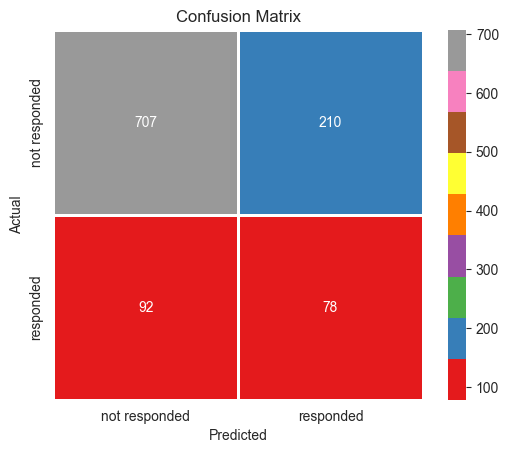

In [39]:
# Erstellen und Trainieren einer neuen Modellinstanz
pipe.set_params(knn__n_neighbors=2, knn__metric = "manhattan", knn__weights="distance").fit(X_train, y_train)
# Vorhersage der Klasse für die finalen Test2 Daten unter Berücksichtigung eines Classification Thresholds von 5%
y_predicted = (pipe.predict_proba(X_test_2)[:,1]>=0.083).astype(bool)
# Ermitteln der Accuracy, Precision, Recall, F1Score und Gewinn/Erlös
accuracy = accuracy_score(y_test_2, y_predicted)
precision = precision_score(y_test_2, y_predicted)
recall = recall_score(y_test_2, y_predicted)
f1score = f1_score(y_test_2, y_predicted)
score = get_result_score(y_test_2, y_predicted)

# Ausgabe der Scores
print("Accuracy: ",accuracy*100, "%")
print("Recall: ", recall*100, "%")
print("Precision: ", precision*100, "%")
print("F1 Score: ", f1score*100, "%")
print("Score: ", score, "€")

## Confusion Matrix der Klassifizierung ausgeben
conf_matrix = confusion_matrix(y_test_2.astype('int'), y_predicted.astype('int'))
class_labels = ['not responded', 'responded']
sns.heatmap(conf_matrix, annot=True, fmt='d', square=True, xticklabels=class_labels,
           yticklabels=class_labels, linewidths=2, linecolor='w', cmap='Set1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Accuracy:  44.06623735050598 %
Recall:  95.88235294117648 %
Precision:  21.335078534031414 %
F1 Score:  34.90364025695932 %
Profit:  1294 €


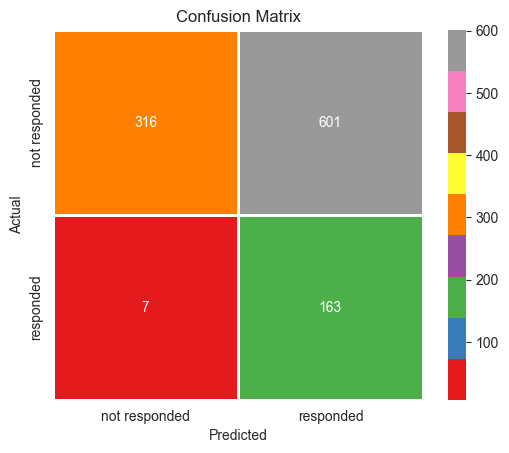

In [40]:
# Erstellen und Trainieren einer neuen Modellinstanz
pipe.set_params(knn__n_neighbors=20, knn__metric = "manhattan", knn__weights="distance").fit(X_train, y_train)
# Vorhersage der Klasse für die finalen Test2 Daten unter Berücksichtigung eines Classification Thresholds von 5%
y_predicted = (pipe.predict_proba(X_test_2)[:,1]>=0.039).astype(bool)
# Ermitteln der Accuracy, Precision, Recall, F1Score und Gewinn/Erlös
accuracy = accuracy_score(y_test_2, y_predicted)
precision = precision_score(y_test_2, y_predicted)
recall = recall_score(y_test_2, y_predicted)
f1score = f1_score(y_test_2, y_predicted)
score = get_result_score(y_test_2, y_predicted)

# Ausgabe der Scores
print("Accuracy: ",accuracy*100, "%")
print("Recall: ", recall*100, "%")
print("Precision: ", precision*100, "%")
print("F1 Score: ", f1score*100, "%")
print("Profit: ", score, "€")

## Confusion Matrix der Klassifizierung ausgeben
conf_matrix = confusion_matrix(y_test_2.astype('int'), y_predicted.astype('int'))
class_labels = ['not responded', 'responded']
sns.heatmap(conf_matrix, annot=True, fmt='d', square=True, xticklabels=class_labels,
            yticklabels=class_labels, linewidths=2, linecolor='w', cmap='Set1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<h2>Baseline Strategie<h2>

In [41]:
# Errechnung des Gewinn/Verlusts bei Befolgung der Baseline Strategie
len(y_test_2)
count_RESP_yes = sum(y_test_2)
count_RESP_no = len(y_test_2) - sum(y_test_2)
baseline = (count_RESP_yes*16)+(count_RESP_no*(-2))
print("Gewinn Baseline Strategie: ",baseline, "€")

Gewinn Baseline Strategie:  886 €


In [42]:
print("Differenz zur Baseline Strategie:", score-baseline, "€")

Differenz zur Baseline Strategie: 408 €
